In [2]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml

sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_docker_image
from docker_utils import push as docker_push
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

In [3]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role("sagemaker")

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::600537146592:role/service-role/AWSDeepRacerSageMakerAccessRole


In [61]:
# Select the instance type
#instance_type = "ml.c4.2xlarge"
# instance_type = "ml.p2.xlarge"
instance_type = "ml.g4dn.2xlarge"

# Starting SageMaker session
sage_session = sagemaker.session.Session()

# Create unique job name.
job_name_prefix = "deepracer-notebook"

# Duration of job in seconds (10 minutes)
job_duration_in_seconds = 1800

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1", "ap-southeast-1","ap-northeast-1","eu-central-1","us-east-2"]:
    raise Exception(
        "This notebook uses RoboMaker which is available only in certain"
        "regions. Please switch to one of these regions."
    )
custom_image_name = "600537146592.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu"
print("Using ECR image %s" % custom_image_name)

Using ECR image 600537146592.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu


### Create a New Job

In [62]:
# S3 bucket
s3_bucket = sage_session.default_bucket()

# SDK appends the job name and output folder
s3_output_path = "s3://{}/".format(s3_bucket)

# Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())
previous_job_name_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()["Account"]

print("Using s3 bucket {}".format(s3_bucket))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket, s3_prefix
    )
)

Using s3 bucket sagemaker-us-east-1-600537146592
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-600537146592/deepracer-notebook-sagemaker-230710-084907


### VPC Configuration

In [63]:
ec2 = boto3.client("ec2")

print("Using the default VPC stacks")
deepracer_vpc = [vpc["VpcId"] for vpc in ec2.describe_vpcs()["Vpcs"] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [
    group["GroupId"]
    for group in ec2.describe_security_groups()["SecurityGroups"]
    if "VpcId" in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc
]

deepracer_subnets = [
    subnet["SubnetId"]
    for subnet in ec2.describe_subnets()["Subnets"]
    if subnet["VpcId"] == deepracer_vpc and subnet["DefaultForAz"] == True
]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the default VPC stacks
Using VPC: vpc-0583f0be47ec9f771
Using security group: ['sg-04d2de6cfe9b1ee4f']
Using subnets: ['subnet-07636419507cea176', 'subnet-0f51ce92b5fb977d5', 'subnet-0deaaa1509dc6c639', 'subnet-0ca0ff0e7a5ddb821', 'subnet-095040efea5ddfe9d', 'subnet-0c9abab1ea2804f32']


### S3 Endpoint

In [64]:
def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [
            route_table["RouteTableId"]
            for route_table in ec2.describe_route_tables()["RouteTables"]
            if route_table["VpcId"] == deepracer_vpc
        ]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)

    if not route_tables:
        raise Exception(
            (
                "No route tables were found. Please follow the VPC S3 endpoint creation "
                "guide by clicking the above link."
            )
        )
    try:
        ec2.create_vpc_endpoint(
            DryRun=False,
            VpcEndpointType="Gateway",
            VpcId=deepracer_vpc,
            ServiceName="com.amazonaws.{}.s3".format(aws_region),
            RouteTableIds=route_tables,
        )
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-01056284e8762a00a']
S3 endpoint already exists.


In [65]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/default.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/default.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://sagemaker-us-east-1-600537146592/deepracer-notebook-sagemaker-230710-084907
upload: src/artifacts/rewards/default.py to s3://sagemaker-us-east-1-600537146592/deepracer-notebook-sagemaker-230710-084907/customer_reward_function.py
upload: src/artifacts/actions/default.json to s3://sagemaker-us-east-1-600537146592/deepracer-notebook-sagemaker-230710-084907/model/model_metadata.json


In [67]:
custom_hyperparameter = {
    "s3_bucket": s3_bucket,
    "s3_prefix": s3_prefix,
    "aws_region": aws_region,
    "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
    "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
    "batch_size": "64",
    "num_epochs": "10",
    "stack_size": "1",
    "lr": "0.001",
    "exploration_type": "Categorical",
    "e_greedy_value": "1",
    "epsilon_steps": "10000",
    "beta_entropy": "0.01",
    "discount_factor": "0.999",
    "loss_type": "mean squared error",
    "num_episodes_between_training": "20",
    "max_sample_count": "0",
    "sampling_frequency": "1"
    #,"pretrained_s3_bucket": "sagemaker-us-east-1-600537146592"
    #,"pretrained_s3_prefix": "deepracer-notebook-sagemaker-230709-144053"
}

In [68]:
b_sagemaker = boto3.client("sagemaker", region_name=aws_region)
training_job = b_sagemaker.create_training_job(
    TrainingJobName=s3_prefix,
    HyperParameters=custom_hyperparameter,
    AlgorithmSpecification={
        "TrainingImage": "{}:latest".format(custom_image_name),
        "TrainingInputMode": "File"
    },
    RoleArn=sagemaker_role,
    OutputDataConfig={
        "S3OutputPath": "s3://{}/{}/train-output/".format(s3_bucket, s3_prefix)
    },
    ResourceConfig={
        'InstanceType': instance_type,
        'InstanceCount': 1,
        'VolumeSizeInGB': 32
    },
    VpcConfig={
        'SecurityGroupIds': deepracer_security_groups,
        'Subnets': deepracer_subnets
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': job_duration_in_seconds
    },
)
job_name = s3_prefix
training_job_arn = training_job['TrainingJobArn']
print("Training job: %s" % job_name)

Training job: deepracer-notebook-sagemaker-230710-084907


In [69]:
robomaker = boto3.client("robomaker")
kinesisvideo = boto3.client("kinesisvideo")

In [70]:
robomaker_environment = {"uri":"600537146592.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook:latest"} # {"uri": get_custom_image_name(local_simapp_ecr_docker_image_name)+":latest"}
simulation_software_suite = {"name": "SimulationRuntime"}
robot_software_suite = {"name": "General"}
print(robomaker_environment)
#600537146592.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook

{'uri': '600537146592.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook:latest'}


In [71]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(
        name=app_name,
        environment=robomaker_environment,
        simulationSoftwareSuite=simulation_software_suite,
        robotSoftwareSuite=robot_software_suite
    )
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application230710-084949
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:600537146592:simulation-application/deepracer-notebook-application230710-084949/1688978989610


### Number of Simulation Job

In [72]:
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1
# kvs_stream_name=[]
# kvs_stream_arns=[]
# for job_no in range(num_simulation_workers):
#     kvs_stream_name.append("dr-kvs-{}-{}".format(job_name,job_no))
#     try:
#         response=kinesisvideo.create_stream(StreamName=kvs_stream_name[job_no],MediaType="video/h264",DataRetentionInHours=24)
#     except Exception as err:
#         if err.__class__.__name__ == 'ResourceInUseException':
#             response=kinesisvideo.describe_stream(StreamName=kvs_stream_name[job_no])["StreamInfo"]
#         else:
#             raise err
#     print("Created kinesis video stream {}".format(kvs_stream_name[job_no]))
#     kvs_stream_arns.append(response["StreamARN"])
    

### Launch Robotmaker Job

In [73]:
s3_yaml_name = "training_params.yaml"
world_name = "Vegas_track"

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["SAGEMAKER_SHARED_S3_BUCKET"] = s3_bucket
yaml_config["SAGEMAKER_SHARED_S3_PREFIX"] = s3_prefix
yaml_config["TRAINING_JOB_ARN"] = training_job_arn
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/training_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)
yaml_config["AWS_REGION"] = aws_region
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
#yaml_config["KINESIS_VIDEO_STREAM_NAME"] = kvs_stream_name[job_no]
yaml_config["REWARD_FILE_S3_KEY"] = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config["NUM_WORKERS"] = num_simulation_workers
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

JOB_TYPE                                : TRAINING
WORLD_NAME                              : Vegas_track
SAGEMAKER_SHARED_S3_BUCKET              : sagemaker-us-east-1-600537146592
SAGEMAKER_SHARED_S3_PREFIX              : deepracer-notebook-sagemaker-230710-084907
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:600537146592:training-job/deepracer-notebook-sagemaker-230710-084907
METRICS_S3_BUCKET                       : sagemaker-us-east-1-600537146592
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-230710-084907/training_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-600537146592
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-230710-084907/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 600537146592
CHANGE_START_POSITION           

In [74]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
       #  compute= { 
       #    "computeType": "GPU_AND_CPU",
       #    "gpuUnitLimit": 1,
       #    "simulationUnitLimit": 15
       # },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "distributed_training.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
                    "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    #"KINESIS_VIDEO_STREAM_NAME": kvs_stream_name[job_no],
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                    "ROLLOUT_IDX": str(job_no),
                    "DEEPRACER_JOB_TYPE_ENV": "SAGEONLY"
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:600537146592:simulation-job/sim-1tlp4bszx37g


### Visualize Job

In [75]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

# for job_no in range(num_simulation_workers):
#     display(Markdown("View the Kinesis video stream <a target=_blank href=\"https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/%s\">here.</a> (Expand 'Media Playback')"%(kvs_stream_name[job_no])))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-1tlp4bszx37g)  

You can click on Gazebo after you open the above link to start the simulator.

In [28]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-sagemaker-v1


In [ ]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
x_axis = "episode"
y_axis = "reward_score"

plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
plt.set_ylabel(y_axis)
plt.set_xlabel(x_axis);

Waiting for s3://sagemaker-us-east-1-600537146592/deepracer-notebook-sagemaker-230709-144053/training_metrics.json...


In [41]:
df

,reward_score,metric_time,start_time,elapsed_time_in_milliseconds,episode,trial,phase,completion_percentage,episode_status
0,30,25995,23568,2427,1,1,training,9,Off track
1,27,28487,26426,2061,2,2,training,6,Off track
2,20,30730,28858,1872,3,3,training,5,Off track
3,17,32579,31034,1545,4,4,training,3,Off track
4,13,34245,32883,1362,5,5,training,2,Off track
...,...,...,...,...,...,...,...,...,...
570,48,2391518,2387041,4477,460,20,evaluation,15,Off track
571,22,2396143,2393095,3048,460,20,evaluation,6,Off track
572,92,2405346,2397402,7944,460,20,evaluation,29,Off track
573,61,2412258,2406994,5264,460,20,evaluation,17,Off track


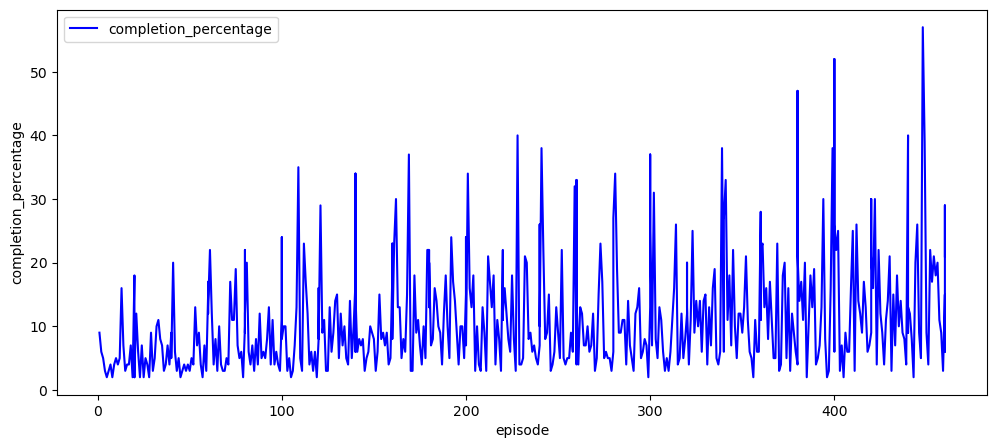

In [42]:
x_axis = "episode"
y_axis = "completion_percentage"

plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
plt.set_ylabel(y_axis)
plt.set_xlabel(x_axis);

## Test DeepRace Model

In [ ]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "Vegas_track"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = s3_bucket
yaml_config["MODEL_S3_PREFIX"] = s3_prefix
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config["NUMBER_OF_TRIALS"] = 3

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "evaluation.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    #"KINESIS_VIDEO_STREAM_NAME": kvs_stream_name[job_no],
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df["elapsed_time"] = df["elapsed_time_in_milliseconds"] / 1000
df = df[["trial", "completion_percentage", "reset_count", "elapsed_time"]]

display(df)

## Clean Up

In [76]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '3f7cf68b-ede9-4a3f-875e-0d31abd111ac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 10 Jul 2023 09:05:53 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '3f7cf68b-ede9-4a3f-875e-0d31abd111ac',
   'access-control-allow-origin': '*',
   'access-control-allow-headers': 'Content-Type,X-Amz-Date,Authorization,X-Api-Key,X-Amz-Security-Token',
   'x-amz-apigw-id': 'H1x9yGqfoAMFcJw=',
   'access-control-allow-methods': 'GET,OPTIONS,POST',
   'access-control-expose-headers': 'x-amzn-RequestId,x-amzn-ErrorType',
   'x-amzn-trace-id': 'Root=1-64abc9f1-2f9c892b7ffe9d1550d4bc1c'},
  'RetryAttempts': 0}}

In [77]:
# Cancelling robomaker job
for job_arn in job_arns:
    try:
        robomaker.cancel_simulation_job(job=job_arn)
    except:
        pass

# Stopping sagemaker training job
try:
    sage_session.sagemaker_client.stop_training_job(TrainingJobName=job_name)
except Exception as err:
    print("Could not stop training job; already stopped?",err)